### IMDB

In [49]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

from nltk.corpus import stopwords

import spacy
import en_core_web_sm
from spacy import displacy
from spacy.util import minibatch, compounding
import scattertext as st

from wordcloud import WordCloud,STOPWORDS

In [2]:
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

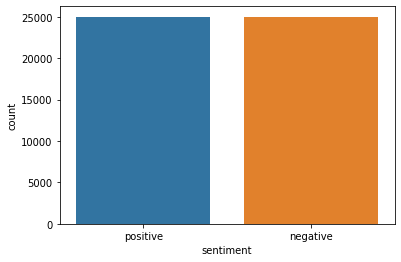

In [8]:
sns.countplot(data['sentiment'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [12]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Sentiment Part

In [18]:
# convert to numerical
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

### Review Part

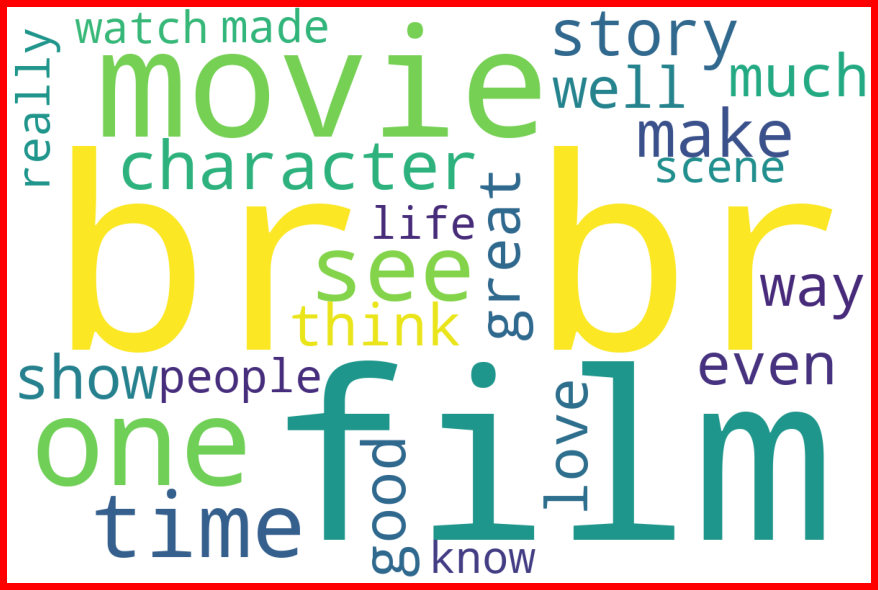

In [21]:
## wordcloud for positive review
positive=data['review'][data['sentiment']==1]
spamcloud=WordCloud(width=1200,height=800,background_color='white',max_words=25).generate(' '.join(positive))

plt.figure(figsize=(12,8),facecolor='r')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

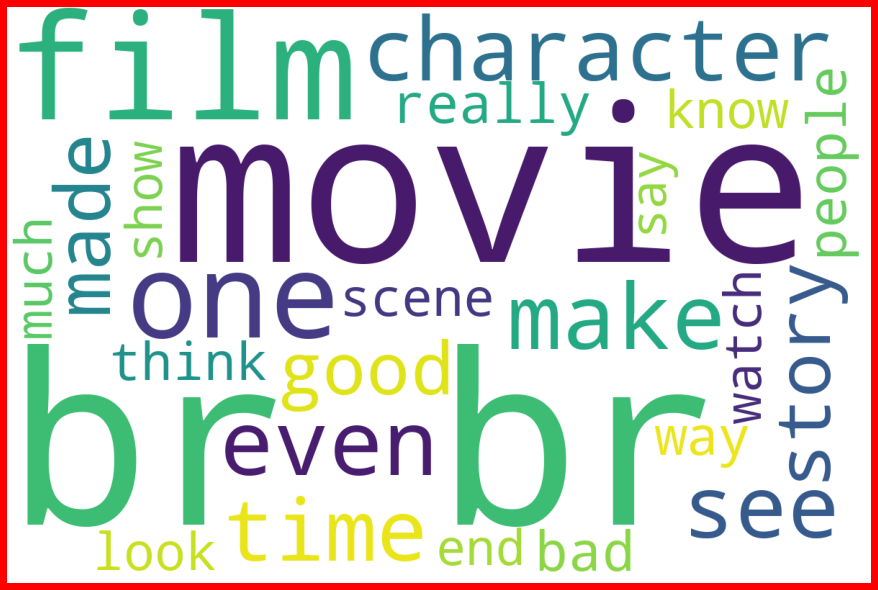

In [22]:
## wordcloud for negative review
positive=data['review'][data['sentiment']==0]
spamcloud=WordCloud(width=1200,height=800,background_color='white',max_words=25).generate(' '.join(positive))

plt.figure(figsize=(12,8),facecolor='r')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [24]:
## remove some unnecessary words such as br from wordcloud we see
# REMOVE UNNECESSARY WORDS FROM DESCRIPTION
data['review'] = data['review'].apply(lambda x: x.replace("<br />", ""))
data['review'] = data['review'].apply(lambda x: x.replace("br", ""))
data['review'] = data['review'].apply(lambda x: x.replace("<p><a", ""))

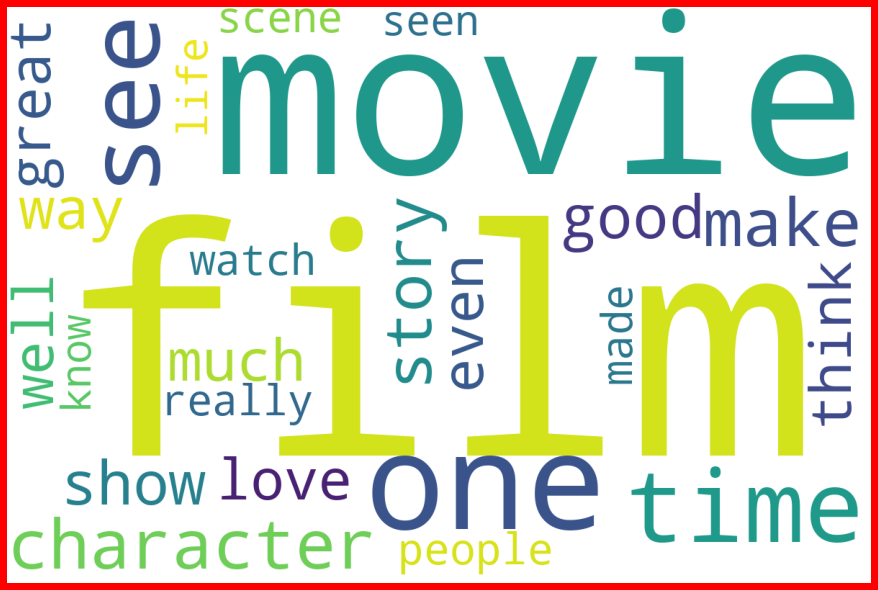

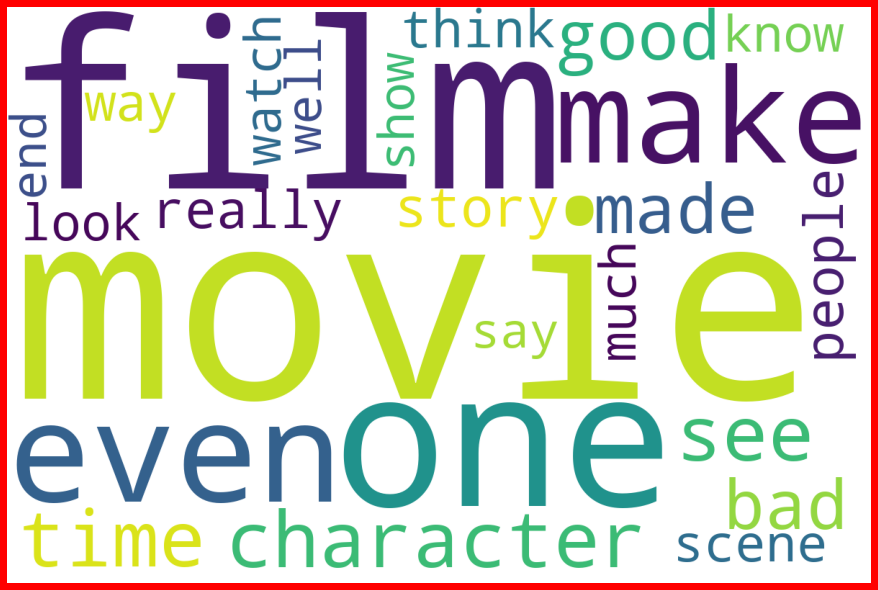

In [25]:
# AFTER REMOVING THESE WORDS CHECK AGAIN
positive=data['review'][data['sentiment']==1]
spamcloud=WordCloud(width=1200,height=800,background_color='white',max_words=25).generate(' '.join(positive))

plt.figure(figsize=(12,8),facecolor='r')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

negative=data['review'][data['sentiment']==0]
spamcloud=WordCloud(width=1200,height=800,background_color='white',max_words=25).generate(' '.join(negative))

plt.figure(figsize=(12,8),facecolor='r')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [33]:
# check duplicate
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 419 duplicate reviews present in the dataset


In [34]:
# drop duplicate rows
data.drop_duplicates(inplace = True)

In [35]:
# check duplicate again
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 0 duplicate reviews present in the dataset


In [36]:
# check unnecessary part of reviews, Find if exists and count
re_urls = r'http\S+'
re_html = r'<.*?>'
re_mentions = r'@\w+' 
re_hastags = r'#\w+'
re_digits = r'\d+'

print("Number of urls in tweets ", data['review'].str.count(re_urls).sum())
print("Number of html tag in tweets ", data['review'].str.count(re_html).sum())
print("Number of mentions in tweets ", data['review'].str.count(re_mentions).sum())
print("Number of hastags in tweets ", data['review'].str.count(re_hastags).sum())
print("Number of digits in tweets ", data['review'].str.count(re_digits).sum())

Number of urls in tweets  128
Number of html tag in tweets  36
Number of mentions in tweets  93
Number of hastags in tweets  431
Number of digits in tweets  77714


In [37]:
# unnecessary tags
re_tag = '&amp'

sum_tag = data['review'].str.contains(re_tag).sum()
print("Before sum : ", sum_tag)

Before sum :  0


In [44]:
# remove unnecessary words that cannot effect classification
def remove_words(text):
    #remove urls
    text = re.sub(re_urls, '', text)
    #remove html
    text = re.sub(re_html, '', text)
    #remove mentions
    text = re.sub(re_mentions,'',text)
    #remove hastags
    text = re.sub(re_hastags, '', text)
    #remove digits
    text = re.sub(re_digits, '', text)
    
    return text

data['review'] = data['review'].apply(lambda x: remove_words(x))

In [45]:
# check again unnecessary part of reviews, Find if exists and count
re_urls = r'http\S+'
re_html = r'<.*?>'
re_mentions = r'@\w+' 
re_hastags = r'#\w+'
re_digits = r'\d+'

print("Number of urls in tweets ", data['review'].str.count(re_urls).sum())
print("Number of html tag in tweets ", data['review'].str.count(re_html).sum())
print("Number of mentions in tweets ", data['review'].str.count(re_mentions).sum())
print("Number of hastags in tweets ", data['review'].str.count(re_hastags).sum())
print("Number of digits in tweets ", data['review'].str.count(re_digits).sum())

Number of urls in tweets  0
Number of html tag in tweets  0
Number of mentions in tweets  0
Number of hastags in tweets  0
Number of digits in tweets  0


In [47]:
#Converting into lower case
data['review']=data['review'].str.lower()

### SENTIMENT CONTINUE

In [51]:
# CHECK COMMON WORDS ON EACH SENTIMENT
positive = Counter(" ".join(data[data['sentiment']== 1]['review']).split()).most_common()
negative = Counter(" ".join(data[data['sentiment']== 0]['review']).split()).most_common()

<AxesSubplot:title={'center':'POSITIVE SENTIMENT COMMON WORDS'}>

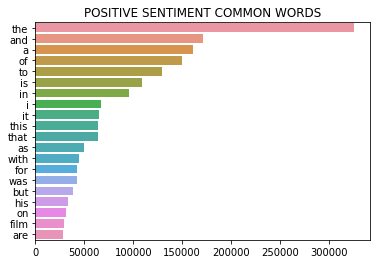

In [52]:
positive_words = [item[0] for item in positive]
positive_counts = [item[1] for item in positive]

plt.title("POSITIVE SENTIMENT COMMON WORDS")
sns.barplot(x=positive_counts[:20], y=positive_words[:20])

<AxesSubplot:title={'center':'NEGATIVE SENTIMENT COMMON WORDS'}>

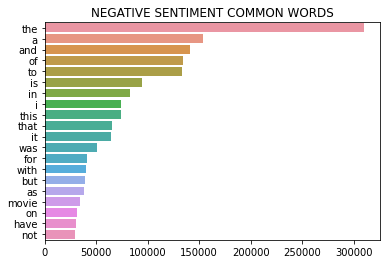

In [53]:
negative_words = [item[0] for item in negative]
negative_counts = [item[1] for item in negative]

plt.title("NEGATIVE SENTIMENT COMMON WORDS")
sns.barplot(x=negative_counts[:20], y=negative_words[:20])